In [1]:
from sklearn.metrics import confusion_matrix, classification_report 
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = confusion_matrix(labels, predicted,normalize = 'all')     
    return  errorScore/len(predicted), myMatrix

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector, catLabels):
    catIndicies = []
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.push(counter)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)

    trainPools = [Pool(data = masterTrainList, label = zScoreTrainList, cat_features = catIndicies),
    Pool(data = masterTrainList, label = fiveDayChangeTrainList, cat_features = catIndicies)]
    testPools = [Pool(data = masterTestList, label = zScoreTestList, cat_features = catIndicies),
    Pool(data = masterTestList, label = fiveDayChangeTestList, cat_features = catIndicies)]
    modelNames = ['ZScorePredictor','FiveDayPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    print('Catboost:')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli')
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model(folderRoot + name + sector + '.mlmodel')
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        print(CatBoostClassifier.get_feature_importance(model, prettified = True))
        error, matrix = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        print('Confusion matrix:\n', matrix)
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    return averageAccuracy, averageScore

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import json
import os
from tabulate import tabulate

def sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector, catLabels):

    folderRoot = 'sciKitPredictors/'
    print('\nSci-Kit:')
    sectorDF.drop(columns = catLabels, inplace = True)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)
    
    
    hyperParamDict = {'accuracy': 0,
    'error_score': -np.inf,
    'min_samples_split': 5,
    'min_impurity_decrease': 0}
    min_samples_splitChoices = [5,15,20,50,100, 200]
    min_impurity_decreaseChoices = [0, 0.00001,0.0001, 0.001, 0.01, 0.05, 0.1, 0.15]
    trainTestBundles = [['zScore', zScoreTrainList, zScoreTestList, hyperParamDict.copy()],
    ['fiveDay',fiveDayChangeTrainList, fiveDayChangeTestList, hyperParamDict.copy()]]

    for minSplit in min_samples_splitChoices:
        for minImpurity in min_impurity_decreaseChoices:
            for bundle in trainTestBundles:
                errorScoreList = []
                accuracyList = []
                for randState in range(3):
                    predictor = RandomForestClassifier(min_samples_split = minSplit, min_impurity_decrease = minImpurity,
                        random_state = randState, n_jobs = 2)
                    predictor.fit(masterTrainList, bundle[1])
                    predictions = predictor.predict(masterTestList)
                    predictionAccuracy = accuracy_score(bundle[2],predictions)
                    feature = pd.DataFrame(predictor.feature_importances_,
                                                        index = sectorDF.columns,
                                                        columns=['importance']).sort_values('importance', ascending=False)
                    errorScore, _ = scoreCalculator(predictor, masterTestList, zScoreTestList)
                    errorScoreList.append(errorScore)
                    accuracyList.append(predictionAccuracy)
                errorScore = sum(errorScoreList)/len(errorScoreList)
                predictionAccuracy = sum(accuracyList)/len(accuracyList)
                if errorScore > bundle[3]['error_score']:
                    bundle[3]['accuracy'] = predictionAccuracy
                    bundle[3]['error_score'] = errorScore
                    bundle[3]['min_samples_split'] = minSplit
                    bundle[3]['min_impurity_decrease'] = minImpurity
    print('Final result:')
    print(trainTestBundles[0][0], ' ', trainTestBundles[0][3])
    print(trainTestBundles[1][0], ' ',trainTestBundles[1][3])
    for bundle in trainTestBundles:
        print('bundle')
        predictor = RandomForestClassifier(min_samples_split = bundle[3]['min_samples_split'], 
        min_impurity_decrease = bundle[3]['min_impurity_decrease'], random_state = 1, n_jobs = 2)
        predictor.fit(masterTrainList, bundle[1])
        
        headers = ["name", "score"]
        values = sorted(zip(sectorDF.columns, predictor.feature_importances_), key=lambda x: x[1] * -1)
        print(tabulate(values, headers, tablefmt="plain"))
        
        _, matrix = scoreCalculator(predictor, masterTestList, zScoreTestList)
        print(bundle[0], ' confusion matrix\n',matrix)
        sector = sector.replace(' ', '_')
        pickle.dump(predictor, open(folderRoot + bundle[0] + sector + '.pkl', 'wb'))
    averageAccuracy = sum([trainTestBundles[x][3]['accuracy'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    averageScore = sum([trainTestBundles[x][3]['error_score'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    return averageAccuracy, averageScore

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
slowVSFastKAMA
aroon
bop
MFI
WilliamsR
zScoreOfChangeTmmrw
percentChangeInFiveDays
typPrice
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
sent
sentChangeSinceYesterday
bPercentSent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEfiveVsTenTickAverage
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOGbPercent
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS8

VolumeZScoreTenDay
highVsLowPerc
MACD
bPercent
slowVSFastKAMA
aroon
MFI
zScoreOfChangeTmmrw
percentChangeInFiveDays
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
UNRATEValue
UNRATEfiveVsTenTickAverage
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS85006092lastChangeP
PRS85006092bPercent
TCUValue
TCUlastChangeP
TCUfiveVsTenTickAverage
TCUbPercent
BOPGSTBValue
BOPGSTBlastChangeP
BOPGSTBbPercent
CPIAUCSLValue
CPIAUCSLfiveVsTenTickAverage
CPIAUCSLbPercent
SFTPINDM114SFRBSFValue
SFTPINDM114SFRBSFlastChangeP
SFTPINDM114SFRBSFfiveVsTenTickAverage
SFTPINDM114SFRBSFbPercent
WALC

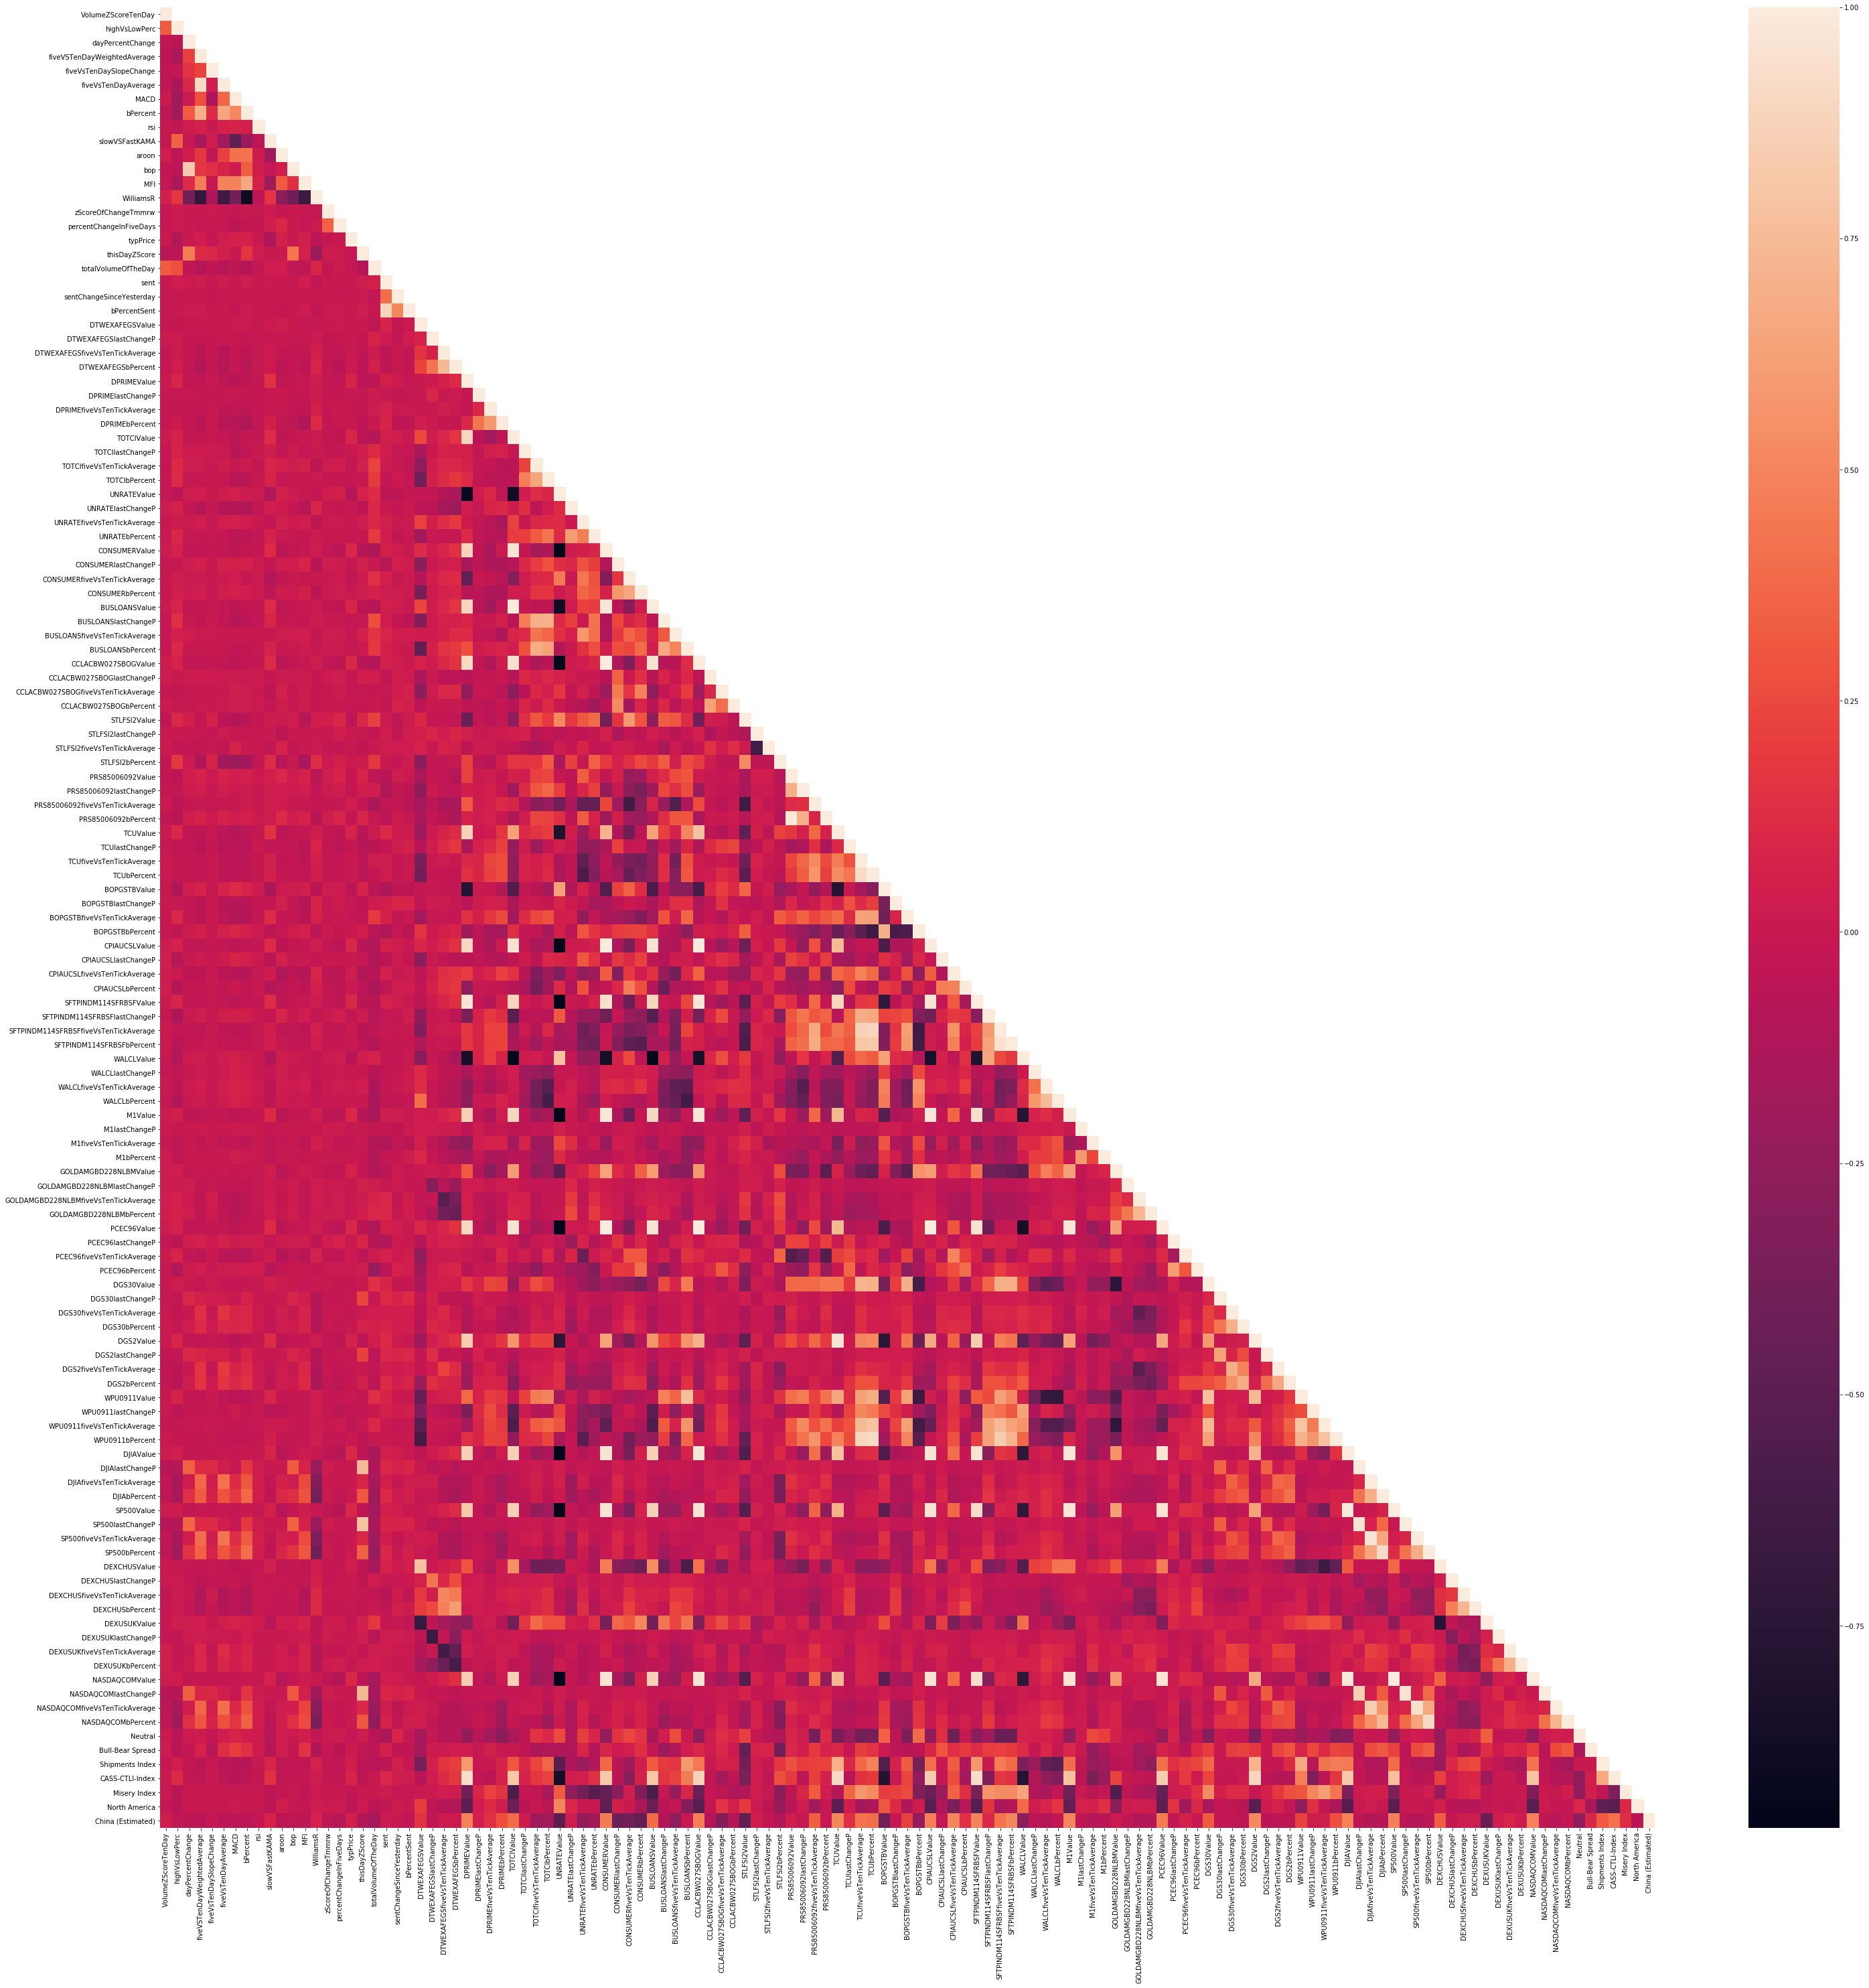

-------------------------------------------


Sector is:  Health Care
Catboost:
ZScorePredictor
Accuracy:  0.6099963293772177
                               Feature Id  Importances
0                          slowVSFastKAMA     4.017935
1                           highVsLowPerc     3.922761
2                      VolumeZScoreTenDay     3.525632
3                       GICS Sub Industry     3.313379
4                                bPercent     2.862391
5                      DEXCHUSlastChangeP     2.767748
6                                     MFI     2.746693
7                                    MACD     2.697160
8                     totalVolumeOfTheDay     2.630261
9                           thisDayZScore     2.569384
10                        DGS2lastChangeP     2.338626
11                                  aroon     2.174417
12                     DEXUSUKlastChangeP     2.143458
13            GOLDAMGBD228NLBMlastChangeP     2.140700
14                  DTWEXAFEGSlastChangeP     2.0

Error Score: 6.143093111464578
Confusion matrix:
 [[0.26538603 0.08577022 0.05499816]
 [0.10332803 0.22091031 0.01712957]
 [0.08772788 0.02281904 0.14193075]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5950895224111913, 'error_score': 3.2585953750152945, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5925200864635589, 'error_score': 1.3786247399975526, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
slowVSFastKAMA                         0.0929662
highVsLowPerc                          0.0928548
bPercent                               0.0887287
VolumeZScoreTenDay                     0.0884511
MACD                                   0.0879325
MFI                                    0.085934
aroon                                  0.0758918
totalVolumeOfTheDay                    0.010457
thisDayZScore                          0.00906849
GOLDAMGBD228NLBMlastChangeP            0.00896444
DEXCHUSla

fiveDay  confusion matrix
 [[0.25308944 0.17135691 0.09788327]
 [0.09249969 0.11146458 0.03725682]
 [0.10436804 0.05408051 0.07800073]]
-------------------------------------------


Sector is:  Industrials
Catboost:
ZScorePredictor
Accuracy:  0.6253723677452491
                               Feature Id  Importances
0                           highVsLowPerc     3.901875
1                          slowVSFastKAMA     3.755177
2                      VolumeZScoreTenDay     3.102586
3                       GICS Sub Industry     2.768565
4                                     MFI     2.734495
5             GOLDAMGBD228NLBMlastChangeP     2.696612
6                      DEXCHUSlastChangeP     2.677155
7                     totalVolumeOfTheDay     2.594375
8                                bPercent     2.510453
9                   DTWEXAFEGSlastChangeP     2.488952
10                     DEXUSUKlastChangeP     2.480277
11                                   MACD     2.461318
12                     

Error Score: 6.236260914227016
Confusion matrix:
 [[0.29388803 0.07745249 0.0492039 ]
 [0.10292758 0.21335388 0.01176168]
 [0.09450437 0.01561376 0.1412943 ]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6187981510015409, 'error_score': 3.3346173600410887, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.621331963704845, 'error_score': 1.3102208525937338, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0945689
slowVSFastKAMA                         0.0915735
VolumeZScoreTenDay                     0.0894918
bPercent                               0.0889717
MACD                                   0.088736
MFI                                    0.0882488
aroon                                  0.0751816
totalVolumeOfTheDay                    0.0106583
DEXUSUKlastChangeP                     0.00921172
NASDAQCOMfiveVsTenTickAverage          0.00897293
SP500bPer

fiveDay  confusion matrix
 [[0.28495121 0.15865434 0.0914227 ]
 [0.10498202 0.10020544 0.03261428]
 [0.10677966 0.0480226  0.07236775]]
-------------------------------------------


Sector is:  Consumer Discretionary
Catboost:
ZScorePredictor
Accuracy:  0.5865081509501936
                               Feature Id  Importances
0                          slowVSFastKAMA     4.915413
1                           highVsLowPerc     4.164343
2                      VolumeZScoreTenDay     3.519558
3                                    MACD     3.044537
4                       GICS Sub Industry     3.025334
5             GOLDAMGBD228NLBMlastChangeP     2.819353
6                                bPercent     2.797157
7                                     MFI     2.768812
8                        DGS30lastChangeP     2.574112
9                                   aroon     2.409944
10                     DEXCHUSlastChangeP     2.387495
11                    totalVolumeOfTheDay     2.340131
12          

Error Score: 6.440601639196614
Confusion matrix:
 [[0.21151941 0.08713861 0.0717824 ]
 [0.08979555 0.21782401 0.02562371]
 [0.08930019 0.03165811 0.17535801]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5787624966225344, 'error_score': 2.8212345011858653, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5607793689393258, 'error_score': 1.1980245579272868, 'min_samples_split': 20, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0996406
slowVSFastKAMA                         0.0988461
VolumeZScoreTenDay                     0.0960593
bPercent                               0.0947088
MACD                                   0.0936258
MFI                                    0.092188
aroon                                  0.0824307
totalVolumeOfTheDay                    0.00902025
DGS30lastChangeP                       0.00835563
DJIAlastChangeP                        0.00832718
thisDay

fiveDay  confusion matrix
 [[0.22318292 0.1699991  0.12262452]
 [0.0847969  0.11208682 0.04714942]
 [0.0883545  0.06525263 0.08655318]]
-------------------------------------------


Sector is:  Information Technology
Catboost:
ZScorePredictor
Accuracy:  0.6307276140002208
                               Feature Id  Importances
0                           highVsLowPerc     3.705429
1                          slowVSFastKAMA     3.460152
2                     totalVolumeOfTheDay     2.985561
3                                bPercent     2.959324
4                      VolumeZScoreTenDay     2.890110
5                      DEXCHUSlastChangeP     2.745256
6                                     MFI     2.718969
7                                    MACD     2.711565
8                           thisDayZScore     2.572220
9                        DGS30lastChangeP     2.401286
10                  DTWEXAFEGSlastChangeP     2.373937
11                                  aroon     2.373680
12          

Error Score: 6.54548967649332
Confusion matrix:
 [[0.25913658 0.09241471 0.048526  ]
 [0.10003312 0.24434139 0.01391189]
 [0.0792757  0.0242354  0.13812521]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6183798903242428, 'error_score': 3.701924846343528, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6148283095947885, 'error_score': 1.4722498251812592, 'min_samples_split': 15, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0931203
slowVSFastKAMA                         0.0893941
bPercent                               0.0880645
VolumeZScoreTenDay                     0.0870759
MACD                                   0.0870053
MFI                                    0.0862846
aroon                                  0.0734867
totalVolumeOfTheDay                    0.012284
NASDAQCOMfiveVsTenTickAverage          0.00972072
SP500bPercent                          0.00970131
thisDa

fiveDay  confusion matrix
 [[0.24975157 0.18212432 0.08440985]
 [0.08518273 0.12840897 0.03257149]
 [0.09959148 0.06563984 0.07231975]]
-------------------------------------------


Sector is:  Consumer Staples
Catboost:
ZScorePredictor
Accuracy:  0.6077890217724624
                               Feature Id  Importances
0                           highVsLowPerc     4.015030
1                          slowVSFastKAMA     3.419460
2                      VolumeZScoreTenDay     3.312649
3                       GICS Sub Industry     3.116311
4                      DEXCHUSlastChangeP     3.042070
5                                bPercent     3.009320
6                        DGS30lastChangeP     2.970327
7                           thisDayZScore     2.938473
8             GOLDAMGBD228NLBMlastChangeP     2.840955
9                                     MFI     2.832018
10                                   MACD     2.663712
11                    totalVolumeOfTheDay     2.472118
12                


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5938532829057208, 'error_score': 2.9394527922586797, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5938873556168865, 'error_score': 0.9262666530375823, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0853609
slowVSFastKAMA                         0.0816545
VolumeZScoreTenDay                     0.0816067
bPercent                               0.0800311
MACD                                   0.0795268
MFI                                    0.0787641
aroon                                  0.069811
totalVolumeOfTheDay                    0.0112728
SP500bPercent                          0.0106209
DEXUSUKlastChangeP                     0.0101678
SP500lastChangeP                       0.0101658
DJIAlastChangeP                        0.0101632
NASDAQCOMfiveVsTenTickAverage          0.0101146
NASDAQCOMlastChangeP   

fiveDay  confusion matrix
 [[0.34253297 0.11928856 0.07513033]
 [0.12593274 0.07615251 0.02851886]
 [0.13165696 0.04119391 0.05959317]]
-------------------------------------------


Sector is:  Utilities
Catboost:
ZScorePredictor
Accuracy:  0.7126241822146838
                               Feature Id  Importances
0                          slowVSFastKAMA     3.625214
1                           highVsLowPerc     3.483160
2             GOLDAMGBD228NLBMlastChangeP     3.468818
3                     totalVolumeOfTheDay     3.161937
4                   DTWEXAFEGSlastChangeP     3.005516
5                      VolumeZScoreTenDay     2.882333
6                                    MACD     2.673115
7                      DEXCHUSlastChangeP     2.658330
8                         DGS2lastChangeP     2.654650
9           NASDAQCOMfiveVsTenTickAverage     2.654404
10                     DEXUSUKlastChangeP     2.652464
11                               bPercent     2.544495
12                       

Sci-Kit:
Final result:
zScore   {'accuracy': 0.7175107018819159, 'error_score': 5.0789516194168485, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.7177126241822146, 'error_score': 1.6436475244325983, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0684332
slowVSFastKAMA                         0.0665772
bPercent                               0.0647202
MACD                                   0.0646866
VolumeZScoreTenDay                     0.0610169
MFI                                    0.0602391
aroon                                  0.048859
totalVolumeOfTheDay                    0.0173162
thisDayZScore                          0.0140253
DEXUSUKlastChangeP                     0.0139603
DJIAlastChangeP                        0.0137479
SP500lastChangeP                       0.0134636
NASDAQCOMlastChangeP                   0.0133456
GOLDAMGBD228NLBMlastChan

-------------------------------------------


Sector is:  Financials
Catboost:
ZScorePredictor
Accuracy:  0.682741116751269
                               Feature Id  Importances
0             GOLDAMGBD228NLBMlastChangeP     3.350260
1                           highVsLowPerc     3.147722
2                          slowVSFastKAMA     3.096715
3                     totalVolumeOfTheDay     2.877655
4                         DGS2lastChangeP     2.730452
5                       GICS Sub Industry     2.609529
6                        DGS30lastChangeP     2.592794
7                      DEXUSUKlastChangeP     2.542168
8                                bPercent     2.516656
9                      VolumeZScoreTenDay     2.479296
10                                   MACD     2.424132
11                  DTWEXAFEGSlastChangeP     2.171878
12                          thisDayZScore     2.134714
13                     DEXCHUSlastChangeP     2.123096
14                                    MFI     2.115

Error Score: 6.842639593908629
Confusion matrix:
 [[0.32402707 0.06858432 0.04664411]
 [0.09373942 0.22588832 0.00671179]
 [0.07969543 0.00834743 0.1463621 ]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6735852603872908, 'error_score': 4.4234818574920105, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6725136303816507, 'error_score': 1.6072570031960893, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0873413
slowVSFastKAMA                         0.087018
bPercent                               0.0845938
MACD                                   0.0839066
VolumeZScoreTenDay                     0.0821286
MFI                                    0.0816118
aroon                                  0.0681721
DJIAbPercent                           0.0111462
totalVolumeOfTheDay                    0.0107147
SP500bPercent                          0.0104384
GOLDAMGBD22

fiveDay  confusion matrix
 [[0.28477157 0.1535251  0.09954879]
 [0.09875917 0.10902425 0.03164129]
 [0.10507614 0.04376763 0.07388607]]
-------------------------------------------


Sector is:  Real Estate
Catboost:
ZScorePredictor
Accuracy:  0.6534083475075232
                               Feature Id  Importances
0                           highVsLowPerc     3.872248
1                          slowVSFastKAMA     3.550247
2                      VolumeZScoreTenDay     3.185544
3                     totalVolumeOfTheDay     2.895630
4                                    MACD     2.791863
5                                bPercent     2.644811
6                   DTWEXAFEGSlastChangeP     2.621952
7             GOLDAMGBD228NLBMlastChangeP     2.602491
8                      DEXUSUKlastChangeP     2.577835
9                                     MFI     2.382615
10                                  aroon     2.316633
11                     DEXCHUSlastChangeP     2.296984
12                     


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6529722185878145, 'error_score': 4.2143137511448385, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6394522220768459, 'error_score': 1.5633041126957128, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0728167
slowVSFastKAMA                         0.0704111
bPercent                               0.0686216
MACD                                   0.0686022
VolumeZScoreTenDay                     0.0658875
MFI                                    0.0656402
aroon                                  0.0564226
totalVolumeOfTheDay                    0.0170335
NASDAQCOMfiveVsTenTickAverage          0.012853
GOLDAMGBD228NLBMlastChangeP            0.0124727
GOLDAMGBD228NLBMbPercent               0.0123466
DEXUSUKlastChangeP                     0.011924
DJIAlastChangeP                        0.011895
DTWEXAFEGSlastChangeP    

-------------------------------------------


Sector is:  Materials
Catboost:
ZScorePredictor
Accuracy:  0.6072077528770442
                               Feature Id  Importances
0                           highVsLowPerc     4.679570
1                          slowVSFastKAMA     3.458975
2                      VolumeZScoreTenDay     3.448501
3                                bPercent     3.328591
4                     totalVolumeOfTheDay     3.048586
5                                    MACD     3.034844
6             GOLDAMGBD228NLBMlastChangeP     3.011280
7                                     MFI     2.765188
8                      DEXUSUKlastChangeP     2.741903
9                         DGS2lastChangeP     2.627079
10                      GICS Sub Industry     2.530725
11                                  aroon     2.462457
12                       DGS30lastChangeP     2.411940
13                          thisDayZScore     2.286961
14                     DEXCHUSlastChangeP     2.237


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6066020593579649, 'error_score': 3.189985867151222, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.5900969109630526, 'error_score': 1.1341611144760753, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0692717
slowVSFastKAMA                         0.0664215
VolumeZScoreTenDay                     0.0644326
MACD                                   0.0634603
bPercent                               0.0633149
MFI                                    0.0628782
aroon                                  0.0527915
totalVolumeOfTheDay                    0.0144405
DGS2lastChangeP                        0.0135662
DEXUSUKlastChangeP                     0.0133083
NASDAQCOMfiveVsTenTickAverage          0.0130406
DGS30lastChangeP                       0.0129404
thisDayZScore                          0.0128643
DJIAlastChangeP

-------------------------------------------


Sector is:  Energy
Catboost:
ZScorePredictor
Accuracy:  0.6344986393133766
                               Feature Id  Importances
0                           highVsLowPerc     3.862406
1                          slowVSFastKAMA     3.856696
2                      VolumeZScoreTenDay     3.264743
3             GOLDAMGBD228NLBMlastChangeP     3.122770
4                     totalVolumeOfTheDay     2.963800
5                                     MFI     2.863667
6                                bPercent     2.753496
7                           thisDayZScore     2.684758
8                      DEXCHUSlastChangeP     2.568525
9                      DEXUSUKlastChangeP     2.568425
10                                   MACD     2.553644
11                  DTWEXAFEGSlastChangeP     2.340625
12                       DGS30lastChangeP     2.327727
13                        DGS2lastChangeP     2.226406
14         DTWEXAFEGSfiveVsTenTickAverage     2.148787


Sci-Kit:
Final result:
zScore   {'accuracy': 0.643220989463401, 'error_score': 4.209231735398785, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6347777545181774, 'error_score': 2.1556416160770357, 'min_samples_split': 20, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.072729
slowVSFastKAMA                         0.0696011
VolumeZScoreTenDay                     0.0668134
MACD                                   0.0654925
bPercent                               0.0654878
MFI                                    0.0636145
aroon                                  0.0537985
totalVolumeOfTheDay                    0.0146093
DEXUSUKlastChangeP                     0.0136386
thisDayZScore                          0.0135799
GOLDAMGBD228NLBMlastChangeP            0.0131175
NASDAQCOMlastChangeP                   0.0127577
DEXCHUSlastChangeP                     0.0126018
DEXCHUSbPercent 

-------------------------------------------


Sector is:  Telecommunications Services
Catboost:
ZScorePredictor
Accuracy:  0.5870809484873263
                               Feature Id  Importances
0                           highVsLowPerc     6.057539
1                          slowVSFastKAMA     3.805704
2                           thisDayZScore     3.158658
3                      VolumeZScoreTenDay     3.006549
4                                   aroon     2.987280
5             GOLDAMGBD228NLBMlastChangeP     2.897047
6                                bPercent     2.619973
7                      DEXUSUKlastChangeP     2.500944
8                         DGS2lastChangeP     2.318619
9                     totalVolumeOfTheDay     2.211979
10                                    MFI     2.178512
11                                   MACD     2.102195
12                       TOTCIlastChangeP     1.966480
13                     DEXCHUSlastChangeP     1.946122
14                        DJIAlas

Final result:
zScore   {'accuracy': 0.5786317797765058, 'error_score': 1.4309076042518398, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001}
fiveDay   {'accuracy': 0.6154265467429818, 'error_score': 1.0779503952030527, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                        score
slowVSFastKAMA                         0.0397831
highVsLowPerc                          0.0396724
VolumeZScoreTenDay                     0.0319462
MACD                                   0.031249
MFI                                    0.0312444
bPercent                               0.0296944
aroon                                  0.0261818
thisDayZScore                          0.0198466
totalVolumeOfTheDay                    0.0194739
DEXUSUKbPercent                        0.0184774
DJIAlastChangeP                        0.0184477
DGS30lastChangeP                       0.0184339
SP500lastChangeP                       0.0172811
GOLDAMGBD228NLBMlastChang

In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)


combinedDF = pd.read_csv('data/masterDF.csv', parse_dates = True)
combinedDF.drop(columns=['tmmrwChngAsPerc', 'Date', 'thisDayAveragePercentChange', 'thisDayPercentChangeStdev',
        'fiveDayWeightedAverage', 'tenDayWeightedAverage', 'fiveDaySlopeChange', 'tenDaySlopeChange', 
        'ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'fiveDayAverage', 'tenDayAverage'], inplace = True)
catLabels = ['ticker','GICS Sub Industry']
combinedDF.dropna(inplace = True)
for col in combinedDF.columns:
    print(col)
myBasicCorr = combinedDF.corr()
print('zScoreOfChangeTmmrw correlation: \n')
print(myBasicCorr['zScoreOfChangeTmmrw'].sort_values())
print('percentChangeInFiveDays correlation: \n')
print(myBasicCorr['percentChangeInFiveDays'].sort_values())
combinedCorr = (myBasicCorr['zScoreOfChangeTmmrw'].abs() + myBasicCorr['percentChangeInFiveDays'].abs())
print('combinedCorr: \n')
print(combinedCorr.sort_values())
correlationRequirement = .02
toDrop = combinedCorr[combinedCorr < correlationRequirement].index
print(toDrop)
combinedDF.drop(columns = toDrop, inplace = True)
for col in combinedDF.columns:
    print(col)
plt.subplots(figsize=(50,50))
myBasicCorr = myBasicCorr.where(np.tril(np.ones(myBasicCorr.shape)).astype(np.bool))
sns.heatmap(myBasicCorr)
plt.show()

print('-------------------------------------------\n\n')
sectorList = combinedDF['GICS Sector'].copy().unique()
catAccuracy = []
catError = []
scikitAccuracy = []
scikitError = []
for sector in sectorList:
    print('Sector is: ', sector)
    sectorDF = combinedDF[combinedDF['GICS Sector'] == sector].copy()
    zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
    zScoreAnswer = zScoreAnswer.astype('float')
    zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
    fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
    fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
    
    sectorDF.drop(columns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'GICS Sector'], inplace = True)
    accuracy, error = catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    catAccuracy.append(accuracy)
    catError.append(error)
    
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    scikitAccuracy.append(accuracy)
    scikitError.append(error)
    print('-------------------------------------------\n\n')
print('Catboost accuracy: ', mean(catAccuracy))
print('Catboost score: ' ,mean(catError))
print('Sci-kit accuracy: ', mean(scikitAccuracy))
print('Sci-kit score: ', mean(scikitError))